# Preconditioned boundary integral formulations

The OptimUS library provides different models to solve acoustic wave propagation. This notebook shows a selection of preconditioners to efficiently solve the model equations.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import optimus

## Specify the physical settings for the simulation

Let us consider a spherical object with unit radius that resembles bone and is embedded in an unbounded region of water. The incident wave field is a plane wave travelling in the positive x-direction.

In [2]:
frequency = 1500
source = optimus.source.create_planewave(frequency)

In [3]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

Let us consider six elements per wavelength for the generation of the surface mesh.

In [4]:
ppwl = 6
meshwidth = material_ext.compute_wavelength(frequency) / ppwl
print("Meshwidth:", meshwidth)

Meshwidth: 0.16469999999999999


In [5]:
geometry = optimus.geometry.shapes.Sphere(element_size=meshwidth)
print("Number of vertices in the grid:", geometry.number_of_vertices())

Number of vertices in the grid: 648


## Simulate the wave model

The OptimUS library uses the Boundary Element Method (BEM) to simulate acoustic wave propagation. Many different boundary integral formulations can be designed to solve the Helmholtz equation and the OptimUS library provides a selection of the most popular and efficient techniques. Furthermore, different preconditioners can be selected to improve the convergence of the linear solver. By default, the mass-matrix preconditioner is used.

Let us compare the mass-matrix preconditioner with the OSRC preconditioner of the PMCHWT formulation.

In [6]:
model_noprec = optimus.model.create_acoustic_model(source, geometry, material_ext, material_int,
                                                   formulation='pmchwt', preconditioner=None)
model_mass = optimus.model.create_acoustic_model(source, geometry, material_ext, material_int,
                                                 formulation='pmchwt', preconditioner='mass')
model_osrc = optimus.model.create_acoustic_model(source, geometry, material_ext, material_int,
                                                 formulation='pmchwt', preconditioner='osrc')

The OSRC preconditioner can take different parameters, to be specified as

```
model_osrc = optimus.model.create_acoustic_model(source, geometry, material_ext, material_int,
                                                 formulation='pmchwt', preconditioner='osrc',
                                                 preconditioner_parameters=osrc_params)
```
where `osrc_params` is a dictionary with the following optional keys:
 1. `wavenumber`: the wavenumber in the OSRC operator, a complex number or a label ('ext', 'int') for the wavenumber in the exterior or interior material;
 1. `damped_wavenumber`: the damped wavenumber in the OSRC operator (complex);
 1. `npade`: the number of expansion terms in the Padé series (positive integer);
 1. `theta`: the branch cut angle in radians for the Padé series (float).

Solving the model requires the assembly of the system matrix and its linear solve with the GMRES algorithm. This can be computationally expensive depending on the grid resolution.

In [7]:
model_noprec.solve()
model_mass.solve()
model_osrc.solve()

In [8]:
print("The PMCHWT formulation without preconditioner was solved in", model_noprec.iteration_count, "GMRES iterations.")
print("The mass-matrix preconditioned PMCHWT formulation was solved in", model_mass.iteration_count, "GMRES iterations.")
print("The OSRC preconditioned PMCHWT formulation was solved in", model_osrc.iteration_count, "GMRES iterations.")

The PMCHWT formulation without preconditioner was solved in 94 GMRES iterations.
The mass-matrix preconditioned PMCHWT formulation was solved in 43 GMRES iterations.
The OSRC preconditioned PMCHWT formulation was solved in 34 GMRES iterations.


The effiency of the preconditioners strongly depends on the numerical parameters of the preconditioner and the acoustic settings. Generally speaking, the OSRC preconditioner is superior at high frequencies and the mass-matrix preconditioner more efficient at low frequencies. Furthermore, OSRC preconditioners are more effective at high-contrast interfaces and multiple scattering. See the references listed at the end for more information.

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [9]:
# Choose the model for visualisation
model = model_osrc

In [10]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(bounding_box=[-3, 4, -3, 3])
postprocess_plane.compute_fields()

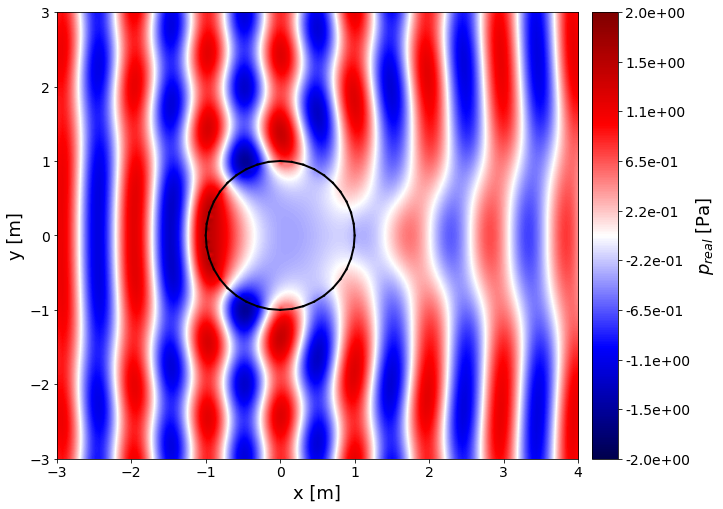

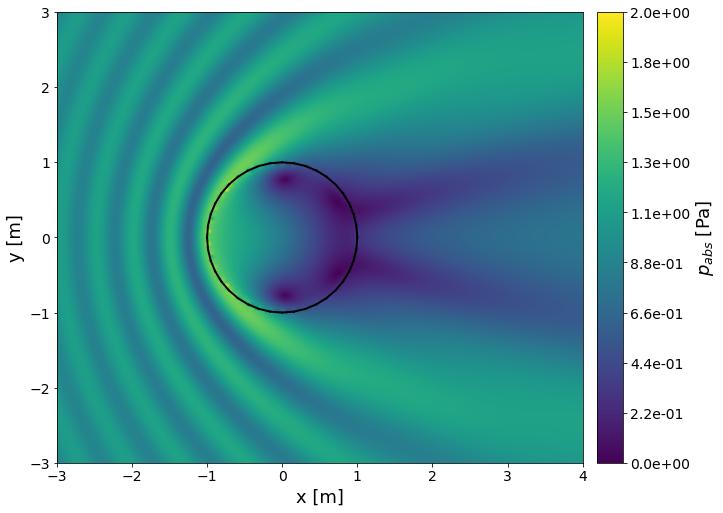

In [11]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane)

## References

More information about preconditioned boundary integral formulations for acoustic transmission problems can be found in the following references to literature:
 1. Benchmarking preconditioned boundary integral formulations for acoustics (https://doi.org/10.1002/nme.6777) 
 1. Frequency-robust preconditioning of boundary integral equations for acoustic transmission (https://doi.org/10.1016/j.jcp.2022.111229)